# Stack Club Course Session 6: Data Products To Science

<br>Owner(s): **Bryce Kalmbach** ([@jbkalmbach](https://github.com/LSSTScienceCollaborations/StackClubCourse/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2020-06-11**
<br>Verified Stack Release: **w_2020_22**

This notebook shows 

### Learning Objectives:

After working through this lesson you should be able to: 
1. Load in difference images and source catalogs using the Butler.
2. Use an Exposure Object to get a WCS for an image.
3. Use the WCS to find objects in the image based upon their ra, dec.
4. Use a photoCalib object to get magnitudes from detected sources in the catalog.
5. Build a lightcurve using the DM stack on real data!

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClubCourse.


#### Further Resources
This notebook uses methods from these other Stack Club notebooks:

[Generating Light Curves from Strongly Lensed Systems in Twinkles data](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Measurement/twinkles_light_curves.ipynb])

[Low-Surface Brightness Source Detection](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/SourceDetection/LowSurfaceBrightness.ipynb)

as well as previous notebooks in the Stack Club Course.

#### Data Credit
The image data in this notebook is DECAM data from the HITS survey processed by Meredith Rawls ([@mrawls](https://github.com/mrawls)) (original dataset location: `/project/mrawls/hits2015/rerun/cw_2020_04`).

## Set-up

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list lsst_distrib -s

nb-brycek-w-2020-22
   19.0.0-1-gc154f85+64 	current w_2020_22 setup


We will need the following packages

In [2]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lsst import geom

from astropy.coordinates import SkyCoord
from astropy import units as u

#%matplotlib widget
%matplotlib inline

In [3]:
import lsst.afw.display as afw_display
afw_display.setDefaultBackend('matplotlib')

## Look at difference images

In [4]:
data_dir = '/project/stack-club/decam_hits_2015_subset/'
#datadir = '/project/mrawls/hits2015/rerun/cw_2020_04'
butler = dafPersist.Butler(data_dir)

Play with Butler and see what is in repo

In [5]:
data_types = butler.getDatasetTypes()
diff_data_types = [x for x in data_types if x.startswith('deepDiff') ]

In [6]:
list(np.sort(list(diff_data_types)))

['deepDiff_config',
 'deepDiff_config_filename',
 'deepDiff_diaSrc',
 'deepDiff_diaSrc_filename',
 'deepDiff_diaSrc_len',
 'deepDiff_diaSrc_md',
 'deepDiff_diaSrc_schema',
 'deepDiff_diaSrc_schema_filename',
 'deepDiff_diaSrc_schema_len',
 'deepDiff_diaSrc_schema_md',
 'deepDiff_differenceExp',
 'deepDiff_differenceExp_bbox',
 'deepDiff_differenceExp_detector',
 'deepDiff_differenceExp_filename',
 'deepDiff_differenceExp_filter',
 'deepDiff_differenceExp_header_wcs',
 'deepDiff_differenceExp_md',
 'deepDiff_differenceExp_photoCalib',
 'deepDiff_differenceExp_sub',
 'deepDiff_differenceExp_visitInfo',
 'deepDiff_differenceExp_wcs',
 'deepDiff_kernelSrc',
 'deepDiff_kernelSrc_filename',
 'deepDiff_kernelSrc_len',
 'deepDiff_kernelSrc_md',
 'deepDiff_kernelSrc_schema',
 'deepDiff_matchedExp',
 'deepDiff_matchedExp_bbox',
 'deepDiff_matchedExp_detector',
 'deepDiff_matchedExp_filename',
 'deepDiff_matchedExp_filter',
 'deepDiff_matchedExp_header_wcs',
 'deepDiff_matchedExp_md',
 'deepDiff_

In [7]:
butler.queryMetadata('deepDiff_differenceExp', ('visit', 'filter'))

[(410865, 'r'),
 (410879, 'r'),
 (410881, 'r'),
 (410915, 'g'),
 (410929, 'g'),
 (410931, 'g'),
 (410971, 'g'),
 (410985, 'g'),
 (410987, 'g'),
 (411021, 'g'),
 (411035, 'g'),
 (411037, 'g'),
 (411055, 'g'),
 (411069, 'g'),
 (411071, 'g'),
 (411255, 'g'),
 (411269, 'g'),
 (411271, 'g'),
 (411305, 'g'),
 (411319, 'g'),
 (411321, 'g'),
 (411355, 'g'),
 (411369, 'g'),
 (411371, 'g'),
 (411406, 'g'),
 (411420, 'g'),
 (411422, 'g'),
 (411456, 'g'),
 (411470, 'g'),
 (411472, 'g'),
 (411657, 'g'),
 (411671, 'g'),
 (411673, 'g'),
 (411707, 'g'),
 (411721, 'g'),
 (411722, 'r'),
 (411724, 'g'),
 (411758, 'g'),
 (411772, 'g'),
 (411774, 'g'),
 (411808, 'g'),
 (411822, 'g'),
 (411824, 'g'),
 (411858, 'g'),
 (411872, 'g'),
 (411874, 'g'),
 (412060, 'g'),
 (412074, 'g'),
 (412076, 'g'),
 (412250, 'g'),
 (412264, 'g'),
 (412266, 'g'),
 (412307, 'g'),
 (412321, 'g'),
 (412322, 'r'),
 (412324, 'g'),
 (412504, 'g'),
 (412518, 'g'),
 (412520, 'g'),
 (412554, 'g'),
 (412568, 'g'),
 (412570, 'g'),
 (412604

Get CalExp

In [8]:
calexp = butler.get('calexp', {'visit': 410929, 'ccdnum': 51, 'filter': 'g'})

In [9]:
# exp_metadata.paramNames()

In [10]:
calexp_im = calexp.getMaskedImage()

Get Visit Info for an Exposure

In [11]:
exp_metadata = butler.get('calexp_md',{'visit': 410929, 'ccdnum': 51, 'filter': 'g'})

In [12]:
# Since we want to get light curves in the end. Let's show how to get the time of the visit.
visit_mjd = exp_metadata['MJD-OBS']
print(visit_mjd)

57070.15938878


Get Source Catalog

In [13]:
calexp_src_cat = butler.get('src', {'visit': 410929, 'ccdnum': 51, 'filter': 'g'})

Get Difference Image

In [14]:
diffexp = butler.get('deepDiff_differenceExp', {'visit': 410929, 'ccdnum': 51, 'filter':'g'})

In [15]:
diffexp_src_cat = butler.get('deepDiff_diaSrc', {'visit': 410929, 'ccdnum': 51, 'filter': 'g'})

In [16]:
diffexp_im = diffexp.getMaskedImage()

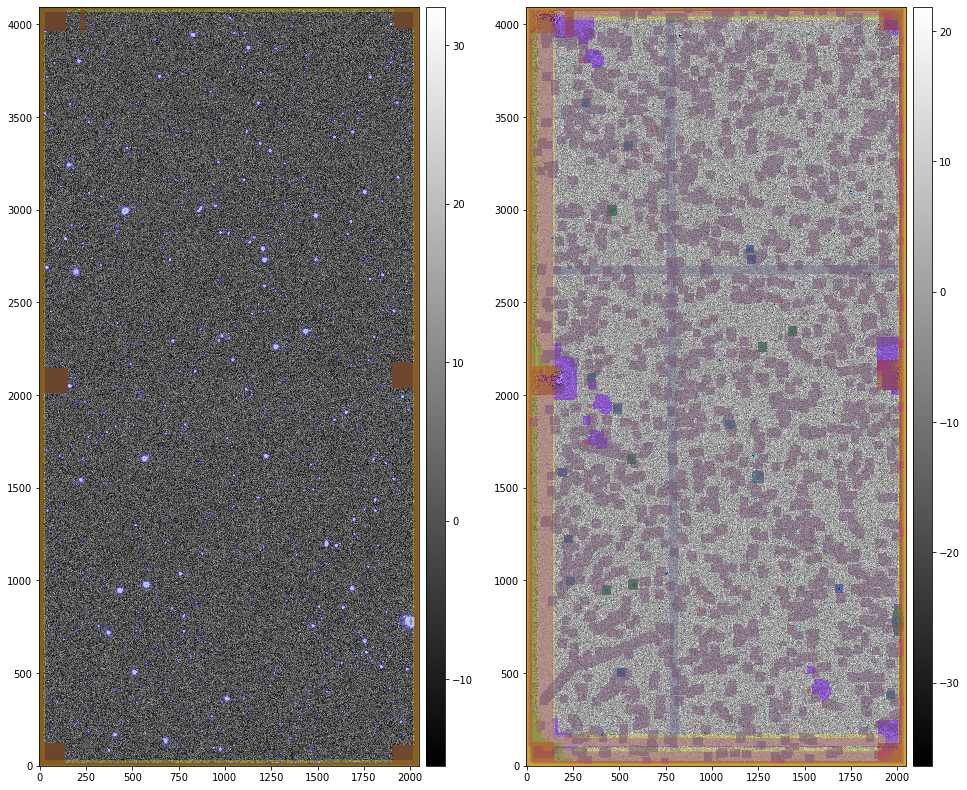

In [17]:
fig = plt.figure(figsize=(16, 14))
display = []

fig.add_subplot(1,2,1)
display.append(afw_display.Display(frame=fig))
display[0].scale('linear', 'zscale')
display[0].mtv(calexp_im)

fig.add_subplot(1,2,2)
display.append(afw_display.Display(frame=fig))
display[1].scale('linear', 'zscale')
display[1].mtv(diffexp_im)

Look at mask bits

In [18]:
mask = diffexp_im.getMask()

In [19]:
mask.getMaskPlaneDict().items()

dict_items([('BAD', 0), ('CLIPPED', 10), ('CR', 3), ('DETECTED', 5), ('DETECTED_NEGATIVE', 6), ('EDGE', 4), ('INEXACT_PSF', 11), ('INTRP', 2), ('NOT_DEBLENDED', 12), ('NO_DATA', 8), ('REJECTED', 13), ('SAT', 1), ('SENSOR_EDGE', 14), ('SUSPECT', 7), ('UNMASKEDNAN', 9)])

In [20]:
mask = diffexp.getMask()
for mask_name, mask_bit in mask.getMaskPlaneDict().items():
    print('{:20}: {}'.format(mask_name, display[1].getMaskPlaneColor(mask_name)))

BAD                 : red
CLIPPED             : None
CR                  : magenta
DETECTED            : blue
DETECTED_NEGATIVE   : cyan
EDGE                : yellow
INEXACT_PSF         : None
INTRP               : green
NOT_DEBLENDED       : None
NO_DATA             : orange
REJECTED            : None
SAT                 : green
SENSOR_EDGE         : None
SUSPECT             : yellow
UNMASKEDNAN         : None


## Loading and using the Exposure WCS

In [21]:
import astropy.units as u
from astropy.coordinates import SkyCoord

Load in astrometry for asteroid we found with KBMOD

In [22]:
hits_object_df = pd.read_csv('hits_kbmod_2015_DQ249_coords.dat', delimiter=' ')

In [23]:
hits_object_df.head()

,visit,year,month,day,ra_hour,ra_min,ra_sec,dec_deg,dec_min,dec_sec
0,410929,2015,2,17.15939,10,19,38.442,-5,56,40.41
1,410985,2015,2,17.24529,10,19,37.616,-5,56,33.08
2,411035,2015,2,17.31416,10,19,36.969,-5,56,27.42
3,411069,2015,2,17.36113,10,19,36.501,-5,56,23.76
4,411269,2015,2,18.08845,10,19,29.672,-5,55,23.12


Find it in visit number 410985. 

Use this one to show that it was not found in the calexp source catalog but *was* found in the difference image source catalog!

In [24]:
hits_first_visit = hits_object_df.loc[1]

In [25]:
data_id = {'visit': hits_first_visit['visit'], 'ccdnum': 9, 'filter':'g'}

In [26]:
diffexp = butler.get('deepDiff_differenceExp', data_id)

In [27]:
diffexp_src_cat = butler.get('deepDiff_diaSrc', data_id)

In [28]:
diffexp_src_df = diffexp_src_cat.asAstropy().to_pandas()

Explore flags. **To Do/Need Help: What would be useful to talk about here? What are best practices?**

In [29]:
[x for x in diffexp_src_df.columns if x.startswith('base_PixelFlags')]

['base_PixelFlags_flag',
 'base_PixelFlags_flag_offimage',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_interpolated',
 'base_PixelFlags_flag_saturated',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_suspect',
 'base_PixelFlags_flag_interpolatedCenter',
 'base_PixelFlags_flag_saturatedCenter',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_suspectCenter']

In [30]:
diffcat_good_srcs = diffexp_src_df.query(str('~base_PixelFlags_flag_bad and ' +
                                             '~base_PixelFlags_flag_suspect and' +
                                             '~base_PixelFlags_flag_saturatedCenter'))

In [31]:
# diffexp_src_cat = butler.get('src', {'visit': hits_first_visit['visit'],
#                                                  'ccdnum': 9, 'filter': 'g'})

Get WCS

In [32]:
wcs = diffexp.getWcs()

In [33]:
wcs

FITS standard SkyWcs:
Sky Origin: (154.787109, -5.951107)
Pixel Origin: (1171.94, 1762.08)
Pixel Scale: 0.262966 arcsec/pixel

Use astropy SkyCoords to translate ra, dec into radians

In [34]:
obj_pos = SkyCoord('%i %i %f %i %i %f' % (hits_first_visit['ra_hour'],
                                          hits_first_visit['ra_min'],
                                          hits_first_visit['ra_sec'],
                                          hits_first_visit['dec_deg'],
                                          hits_first_visit['dec_min'],
                                          hits_first_visit['dec_sec']),
                   unit=(u.hourangle, u.degree))

In [35]:
obj_pos.ra.deg, obj_pos.dec.deg

(154.9067333333333, -5.942522222222222)

Use `lsst.geom` package to create `SpherePoint` that describes a position on the sky.

`geom` also has units that we can provide.

In [36]:
obj_pos_lsst = geom.SpherePoint(obj_pos.ra.deg, obj_pos.dec.deg, geom.degrees)

In [37]:
x_pix, y_pix = wcs.skyToPixel(obj_pos_lsst)

In [38]:
x_half_width = 40
y_half_width = 40

Use `Factory` method to create cutouts

In [39]:
# Define bounding box for cutout
bbox = geom.Box2I()
bbox.include(geom.Point2I(x_pix - x_half_width, y_pix - y_half_width))
bbox.include(geom.Point2I(x_pix + x_half_width, y_pix + y_half_width))

In [40]:
# Generate cutout with Factory
calexp_cutout = calexp.Factory(calexp, bbox, origin=afwImage.LOCAL, deep=False)

In [41]:
# Generate cutout with Factory
diffexp_cutout = diffexp.Factory(diffexp, bbox, origin=afwImage.LOCAL, deep=False)

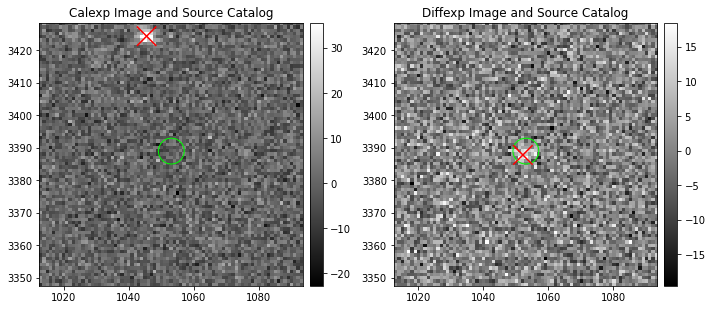

In [42]:
fig = plt.figure(figsize=(10, 5))
stamp_display = []

fig.add_subplot(1,2,1)
stamp_display.append(afw_display.Display(frame=fig))
stamp_display[0].scale('linear', 'zscale')
stamp_display[0].mtv(calexp_cutout.image)

stamp_display[0].dot('o', x_pix, y_pix, size=4)
for src in calexp_src_cat:
    stamp_display[0].dot('x', src.getX(), src.getY(), ctype='r', size=4)
plt.title('Calexp Image and Source Catalog')
    
fig.add_subplot(1,2,2)
stamp_display.append(afw_display.Display(frame=fig))
stamp_display[1].scale('linear', 'zscale')
stamp_display[1].mtv(diffexp_cutout.image)

stamp_display[1].dot('o', x_pix, y_pix, size=4)
for src in diffexp_src_cat:
    stamp_display[1].dot('x', src.getX(), src.getY(), ctype='r', size=4)
plt.title('Diffexp Image and Source Catalog')

plt.tight_layout()

Object appears in Difference Image Source Catalog but not in Calexp Source Catalog. Yay Difference Images!

In [43]:
diffcat_good_srcs.head()

,id,coord_ra,coord_dec,parent,flags_negative,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,...,ip_diffim_DipoleFit_flag_classification,ip_diffim_DipoleFit_flag_classificationAttempted,ip_diffim_DipoleFit_flag,ip_diffim_DipoleFit_flag_edge,ip_diffim_forced_PsfFlux_instFlux,ip_diffim_forced_PsfFlux_instFluxErr,ip_diffim_forced_PsfFlux_area,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge
6,176516752069361827,2.699460,-0.104738,0,False,1857.139712,138.411625,False,False,False,...,False,False,True,False,10303.115988,82.953403,48.433445,False,False,False
7,176516752069361828,2.699464,-0.104821,0,False,1922.233408,142.253106,False,False,False,...,False,False,True,False,10044.532465,75.284360,48.233650,False,False,False
14,176516752069361835,2.699652,-0.102889,0,False,407.304390,283.291108,False,False,False,...,True,True,False,False,301377.285501,346.838696,50.233772,False,False,False
16,176516752069361837,2.699723,-0.102622,0,False,191.527995,339.555757,False,False,False,...,True,True,False,False,105521.962921,211.392990,50.286949,False,False,False
17,176516752069361838,2.699753,-0.103683,0,False,1029.109394,364.151246,False,False,False,...,False,False,True,False,21868.798425,95.577680,49.270866,False,False,False


Show source matching with Astropy

In [44]:
visit_coords = SkyCoord(diffcat_good_srcs['coord_ra']*u.rad, diffcat_good_srcs['coord_dec']*u.rad)

In [45]:
idx, sep2d, sep3d = obj_pos.match_to_catalog_sky(visit_coords)
print(idx, sep2d.arcsec)

38 [0.39408103]


In [46]:
diffcat_good_srcs.iloc[idx].name

84

In [47]:
obj_instFlux = diffexp_src_cat.getPsfInstFlux()[84]
print(obj_instFlux)

355.4253564211041


But what if we want magnitudes?

Use `photoCalib` product.

In [48]:
deepDiff_photoCalib = butler.get('deepDiff_differenceExp_photoCalib', data_id)

In [49]:
obj_g_mag = deepDiff_photoCalib.instFluxToMagnitude(obj_instFlux)
print(obj_g_mag)

23.63191787346009


**To do: Loop through other visits and finish light curve**